In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/jeremy2/Documents/UMICH/Research/realsense-tracking'

In [131]:
try:
   import cPickle as pickle
except:
   import pickle
import re
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from shapely.geometry import Polygon, box
import shapely
import numpy as np
from landing.helper.o3d_util import create_linemesh_from_shapely, get_segments, _MeshTransmissionFormat, plot_polygons
from pathlib import Path
%matplotlib notebook  

## Plot Extracted Polygons

In [134]:
def flip_columns(array):
    array[:, [1, 0]] = array[:, [0, 1]]
    return array
def handle_multipolygon(polygon):
    if polygon.type == 'MultiPolygon':
        poly = None
        max_area = 0.0
        for geom in polygon.geoms:
            if geom.area > max_area:
                max_area = geom.area
                poly = geom
        return poly
    else:
        return polygon

def flip_xy(polygon):
    polygon = handle_multipolygon(polygon)
    exterior = flip_columns(np.array(polygon.exterior))
    holes = []
    for hole in polygon.interiors:
        holes.append(flip_columns(np.array(hole)))
    poly = Polygon(shell=exterior, holes=holes)
    return poly

def adjust_axes(ax):
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel("Y (m)")
    ax.set_ylabel("X (m)")
    ax.invert_yaxis()
    ax.invert_xaxis()
    


def parse_timings(fname):
    regex_str = "Volume Integration took: (\d*[.]\d*)"
    p = re.compile(regex_str)
    integration_times = []
    with open(fname, 'r') as fh:
        for line in fh:
            a = p.search(line)
            if a is not None:
                integration_times.append(float(a.groups()[0]))
    return np.array(integration_times)

In [135]:
data_dir = Path("assets/data/analysis")
saved = data_dir / "man_.pkl"
saved = [data_dir / f"man_{i+1}.pkl" for i in range(5)]
data = [pickle.load(open(save, 'rb')) for save in saved]
for dat in data:
    dat['mesh'] = dat['mesh'].create_mesh()
# T265 Initialized to far forward on 4th run
data[3]['polygon'] = shapely.affinity.translate(data[3]['polygon'], xoff=0.1)

In [136]:
work_space = box(-1.75, -1.75, 1.75, 1.75)
small_box = box(0, 0,0.158, 0.254)
small_box = shapely.affinity.translate(small_box, xoff=1.21, yoff=1.0)

phantom_box = box(0, 0,0.362, 0.387)
phantom_box = shapely.affinity.translate(phantom_box, xoff=-1.15, yoff=.72)

medium_box = box(0, 0,.24, .42)
medium_box = shapely.affinity.translate(medium_box, xoff=-1.1, yoff=-.889)

ladder = box(0, 0, .43, .66)
ladder = shapely.affinity.translate(ladder, xoff=.1, yoff=.5)
ladder = shapely.affinity.rotate(ladder, angle=65, origin='centroid')

work_space_holes = work_space.difference(small_box).difference(phantom_box).difference(medium_box).difference(ladder)

for dat in data:
    dat['polygon_clipped'] = dat['polygon'].intersection(work_space)


## Plot Workspace

<IPython.core.display.Javascript object>


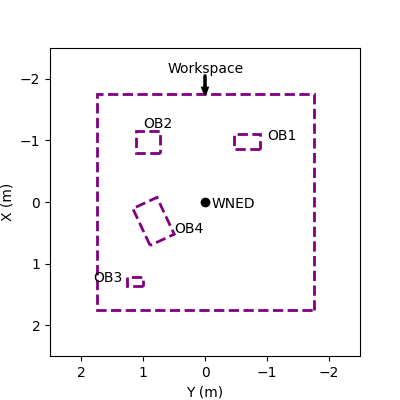

In [137]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
# plot_polygons([data[0]['polygon_clipped']], ax)
# plot_polygons([data[1]['polygon_clipped']], ax, shell_color='red', hole_color='red')
plot_polygons([flip_xy(work_space_holes)],ax, shell_color='purple', hole_color='purple', linestyle='dashed')
adjust_axes(ax)
ax.scatter(0,0, c='k')
ax.text(-0.1,0.1, "WNED")
ax.text(-1, -1, "OB1")
ax.text(1, -1.2, "OB2")
ax.text(1.8, 1.3, "OB3")
ax.text(0.5, 0.5, "OB4")
ax.text(0.6, -2.1, "Workspace")
ax.arrow(0, -2.05, 0, 0.2, head_width=0.075, head_length=0.1, fc='k', ec='k', linewidth=2.0)
plt.savefig("assets/images/workspace_plot.pdf", bbox_inches='tight')

## Plot Polygons

<IPython.core.display.Javascript object>


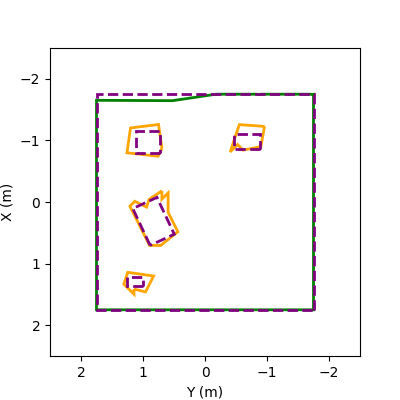

<IPython.core.display.Javascript object>


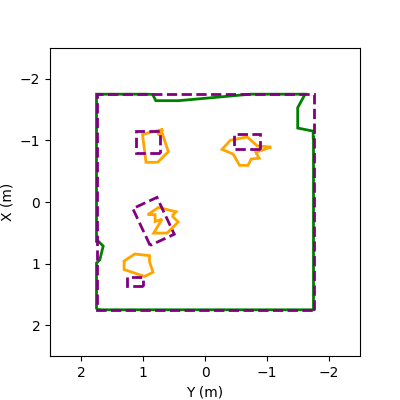

<IPython.core.display.Javascript object>


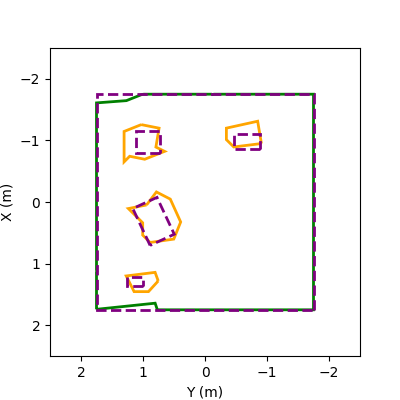

<IPython.core.display.Javascript object>


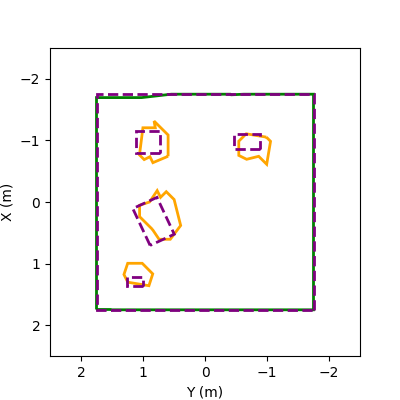

<IPython.core.display.Javascript object>


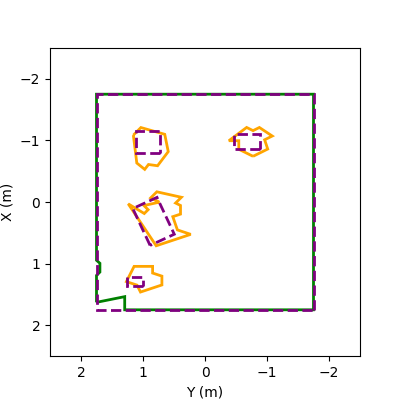

In [138]:
for i, dat in enumerate(data):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    plot_polygons([flip_xy(dat['polygon_clipped'])], ax)
    plot_polygons([flip_xy(work_space_holes)],ax, shell_color='purple', hole_color='purple', linestyle='dashed')
    adjust_axes(ax)
    fig.savefig(f"assets/images/man_poly_{i+1}.pdf", bbox_inches='tight')

In [85]:
for dat in data:
    dat['iou'] = dat['polygon_clipped'].intersection(work_space_holes).area / (dat['polygon_clipped'].union(work_space_holes).area)
    print(f"IOU: {dat['iou']:.3f} ")

print(f"Mean IOU: {np.mean([dat['iou'] for dat in data]):.3f}")

IOU: 0.959 
IOU: 0.912 
IOU: 0.949 
IOU: 0.950 
IOU: 0.945 
Mean IOU: 0.943


## Execution Timing

In [130]:
integration_server_logs = [data_dir / f"rs-integrate-server_man_{i+1}.log" for i in range(5)]

integration_times = [np.array(parse_timings(log_file)) for log_file in integration_server_logs]
all_integration_times = np.concatenate(integration_times)
print(stats.describe(all_integration_times))
print()
details = [dict(mean=np.mean(times), count=np.count_nonzero(times)) for times in integration_times]
print(details)

DescribeResult(nobs=557, minmax=(1.899, 150.916), mean=26.138253141831242, variance=983.0303971102644, skewness=1.647348244825672, kurtosis=1.8061383249138512)

[{'mean': 27.069634782608695, 'count': 115}, {'mean': 21.066654205607477, 'count': 107}, {'mean': 25.731363636363636, 'count': 110}, {'mean': 26.497385245901636, 'count': 122}, {'mean': 30.37607766990291, 'count': 103}]


In [133]:
df = pd.read_csv(data_dir / 'alg_timings.csv')
df.mean()

uid                       3.000000
t_fastga_total            6.810339
t_fastga_integrate        0.979763
t_fastga_peak             5.830576
t_polylidar_planepoly     4.467761
t_polylidar_filter       37.199716
t_bilateral               6.692505
t_polylabel               0.237012
 t_mesh_extraction       50.200600
dtype: float64

## Mesh Visualization